In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def TDT(b,c):
    if b+c == 0:
        return 0
    else:
        return ((b-c)**2)/(b+c)

In [3]:
def LS(b,c,N): #local sensitivity
    stat = TDT(b,c)
    M = stat; m = stat
    
    if b >= 2:
        v = [TDT(b-2,c), TDT(b-2,c+1), TDT(b-2,c+2)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b >= 1:
        v = [TDT(b-1,c), TDT(b-1,c+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b >= 1 and c >= 1:
        v = TDT(b-1,c-1)
        M = max([v,M])
        m = min([v,m])
    if c >= 2:
        v = [TDT(b,c-2), TDT(b+1,c-2), TDT(b+2,c-2)]
        M = max([max(v),M])
        m = min([min(v),m])
    if c >= 1:
        v = [TDT(b,c-1), TDT(b+1,c-1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b+c <= 2*N-2:
        v = [TDT(b+1,c+1), TDT(b,c+2), TDT(b+2,c)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b+c <= 2*N-1:
        v = [TDT(b,c+1), TDT(b+1,c)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b+c <= 2*N-1 and b >= 1:
        v = TDT(b-1,c+2)
        M = max([v,M])
        m = min([v,m])
    if b+c <= 2*N-1 and c >= 1:
        v = TDT(b+2,c-1)
        M = max([v,M])
        m = min([v,m])
    
    return max([M-stat, stat-m])

In [4]:
def d(x,b,c): # From Lemma 3
    if b >= x[0] and c >= x[1]:
        return math.ceil(((b+c)-(x[0]+x[1]))/2)
    elif b <= x[0] and c <= x[1]:
        return math.ceil(((x[0]+x[1])-(b+c))/2)
    else:
        return math.ceil(max([math.fabs(b-x[0]), math.fabs(c-x[1])])/2)
    
def gd(x,N):
    return min([d(x,0,2*N), d(x,2,2*N-2), d(x,2*N-2,2), d(x,2*N,0)])

def ud(x,N): # T = 6 # From Lemma 2
    sd = 10000
    for c in range(int(N/4)):
        s = 9+7*c
        for b in range(s,2*N-c+1):
            sd = min([d(x,b,c),d(x,b-2,c+2),sd])
    for b in range(int(N/4)):
        s = 9+7*b
        for c in range(s,2*N-b+1):
            sd = min([d(x,b,c),d(x,b+2,c-2),sd])
    return sd

In [5]:
def EM(x,eps,N,m):
    u = np.zeros(m); v = np.zeros(m)
    eta = 2*(8*(N-1)/N)/eps
    for i in range(m):
        u[i] = TDT(x[i][0],x[i][1])
        v[i] = u[i] + np.random.gumbel(0,eta,1)
    return np.argmax(v)

def PF(x,eps,N,m):
    u = np.zeros(m); v = np.zeros(m)
    beta = 2*(8*(N-1)/N)/eps
    for i in range(m):
        u[i] = TDT(x[i][0],x[i][1])
        v[i] = u[i] + np.random.exponential(beta,1)
    return np.argmax(v)

In [6]:
def h4(z):
    return np.sqrt(2)/(math.pi*(1+z**4))

def h4_OS(z):
    if z < 0:
        return 0
    else:
        return 2*np.sqrt(2)/(math.pi*(1+z**4))

def cdf(x,h):
    return integrate.quad(h,-oo,x)

#def noise(h): # using inverse transform sampling
#    r = np.random.rand()
#    d = 1000; z = 10
#    for i in range(-1000,1000):
#        if math.fabs(r - cdf(i/100,h)[0]) > d:
#            z = (i-1)/100
#            break
#        else:
#            d = min(d, math.fabs(r - cdf(i/100,h)[0]))
#    return z

def noise(h,CDF):
    rr = np.random.rand()
    l = 0; r = 2000
    while(1):
        t = (int)((l+r)/2)
        if CDF[t] >= rr:
            r = t
        else:
            l = t
        if r-l <= 1:
            z = (((l+r)/2)-1000)/100
            break
    return z

def SPS_g(x,eps,N,m,gamma,CDF): #Smooth Private Selection, gd(x), Two-Sided noise #N = 150, gamma = 4
    GS = 8*(N-1)/N; lbeta = math.log(GS/LS(0,299,N))/gd([0,299],N)
    alpha = eps/(2*((gamma-1)**((gamma-1)/gamma)))
    beta = eps/(2*(gamma-1)); lbeta = min(lbeta,beta/m)
    k = 1 - m*lbeta/(2*beta)
    u = np.zeros(m); v = np.zeros(m)
    s = np.zeros(m)
    
    for i in range(m):
        u[i] = TDT(x[i][0],x[i][1])
        if gd(x[i],N) == 0:
            s[i] = GS
        else:
            s[i] = GS*math.exp(-lbeta*gd(x[i],N))
            
    S = max(s)
    for i in range(m):
        v[i] = u[i] + (S/(k*alpha))*noise(h4,CDF)
    
    return np.argmax(v)

def SPS_g_OS(x,eps,N,m,gamma,CDF): #Smooth Private Selection, gd(x), One-Sided noise #N = 150, gamma = 4
    GS = 8*(N-1)/N; lbeta = math.log(GS/LS(0,299,N))/gd([0,299],N)
    alpha = eps/(2*((gamma-1)**((gamma-1)/gamma)))
    beta = eps/(2*(gamma-1)); lbeta = min(lbeta,beta/(m-1))
    k = 1 - (m-1)*lbeta/(2*beta)
    u = np.zeros(m); v = np.zeros(m)
    s = np.zeros(m)
    
    for i in range(m):
        u[i] = TDT(x[i][0],x[i][1])
        if gd(x[i],N) == 0:
            s[i] = GS
        else:
            s[i] = GS*math.exp(-lbeta*gd(x[i],N))
            
    S = max(s)
    for i in range(m):
        v[i] = u[i] + (S/(k*alpha))*noise(h4_OS,CDF)
    
    return np.argmax(v)
    

def SPS_u(x,eps,N,m,gamma,CDF): #Smooth Private Selection, ud(x), Two-Sided noise #N = 150, gamma = 4
    GS = 8*(N-1)/N; lbeta = math.log(GS/LS(91,209,N))/ud([91,209],N)
    alpha = eps/(2*((gamma-1)**((gamma-1)/gamma)))
    beta = eps/(2*(gamma-1)); lbeta = min(lbeta,beta/m)
    k = 1 - m*lbeta/(2*beta)
    u = np.zeros(m); v = np.zeros(m)
    s = np.zeros(m)
    
    for i in range(m):
        u[i] = TDT(x[i][0],x[i][1])
        if LS(x[i][0],x[i][1],N) > 6:
            s[i] = GS
        else:
            s[i] = GS*math.exp(-lbeta*ud(x[i],N))
            
    S = max(s)
    for i in range(m):
        v[i] = u[i] + (S/(k*alpha))*noise(h4,CDF)
    
    return np.argmax(v)

def SPS_u_OS(x,eps,N,m,gamma,CDF): #Smooth Private Selection, gd(x), One-Sided noise #N = 150, gamma = 4
    GS = 8*(N-1)/N; lbeta = math.log(GS/LS(91,209,N))/ud([91,209],N)
    alpha = eps/(2*((gamma-1)**((gamma-1)/gamma)))
    beta = eps/(2*(gamma-1)); lbeta = min(lbeta,beta/(m-1))
    k = 1 - (m-1)*lbeta/(2*beta)
    u = np.zeros(m); v = np.zeros(m)
    s = np.zeros(m)
    
    for i in range(m):
        u[i] = TDT(x[i][0],x[i][1])
        if LS(x[i][0],x[i][1],N) > 6:
            s[i] = GS
        else:
            s[i] = GS*math.exp(-lbeta*ud(x[i],N))
            
    S = max(s)
    for i in range(m):
        v[i] = u[i] + (S/(k*alpha))*noise(h4_OS,CDF)
    
    return np.argmax(v)

In [7]:
def generateData(N):
    d = np.zeros(2)
    s = np.random.binomial(int(2*N),2/3)
    d[0] = np.random.binomial(s,1/2)
    d[1] = s-d[0]
    return d

In [8]:
def RankError(N,m,CDF,CDF_OS):
    RE = np.zeros((7,6))
    x = np.zeros((m,2)); stats = np.zeros((m,2))
    
    for j in range(40):
        for i in range(m):
            x[i] = generateData(N)
            stats[i][0] = TDT(x[i][0],x[i][1])
            stats[i][1] = i
        sstats = sorted(stats,key=lambda x:(x[0]),reverse=True)
        sx = np.zeros((m,2))
        for i in range(m):
            sx[i] = x[int(sstats[i][1])]
        
        for i in range(7):
            a = EM(sx,3*(i+1),N,m); b = PF(sx,3*(i+1),N,m)
            c = SPS_g(sx,3*(i+1),N,m,4,CDF); d = SPS_g_OS(sx,3*(i+1),N,m,4,CDF_OS)
            e = SPS_u(sx,3*(i+1),N,m,4,CDF); f = SPS_u_OS(sx,3*(i+1),N,m,4,CDF_OS)
            RE[i][0] += a; RE[i][1] += b 
            RE[i][2] += c; RE[i][3] += d;
            RE[i][4] += e; RE[i][5] += f 
            
    return RE/40

[[7.85  9.55  8.825 5.15  8.825 5.325]
 [6.85  6.425 6.8   5.2   4.3   1.375]
 [4.25  4.375 3.6   2.675 2.05  0.7  ]
 [2.875 1.675 5.025 2.2   1.175 0.375]
 [1.55  2.    4.    1.075 1.15  0.25 ]
 [1.125 1.1   2.05  0.375 0.325 0.075]
 [0.925 1.125 1.475 0.3   0.25  0.075]]
[[7.7   7.725 9.425 8.    9.15  5.95 ]
 [5.575 5.975 7.45  6.    6.    2.025]
 [4.525 4.975 5.025 3.025 2.475 1.375]
 [3.9   2.85  5.25  1.525 1.65  0.25 ]
 [2.8   1.65  3.525 1.125 0.825 0.2  ]
 [1.85  1.075 2.975 0.9   1.35  0.1  ]
 [0.7   1.175 2.6   0.375 0.575 0.15 ]]
[[8.3   9.425 7.25  6.125 8.325 6.25 ]
 [5.925 6.2   8.1   5.45  4.55  1.325]
 [5.825 5.275 5.675 2.65  3.55  0.925]
 [2.9   3.625 4.3   1.475 1.825 0.125]
 [2.2   1.9   3.95  0.475 1.55  0.4  ]
 [2.575 2.425 3.475 0.9   0.425 0.175]
 [1.7   0.825 2.75  0.575 1.    0.1  ]]
[[7.525 7.95  8.175 5.75  8.875 6.125]
 [6.175 5.05  7.7   3.6   5.625 2.025]
 [4.725 3.2   5.9   3.375 3.1   1.125]
 [3.45  2.625 5.225 1.825 1.8   0.275]
 [3.5   1.45  2.925 1.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


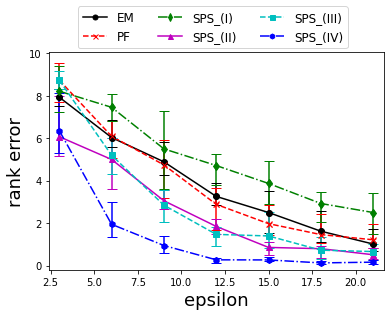

In [9]:
N = 150; m = 20

RE = np.zeros((7,6))
max_RE = np.zeros((7,6)); min_RE = 5*np.ones((7,6))
sum_RE = np.zeros((7,6))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,6))

for i in range(7):
    epsilon[i] = 3*(i+1)
    
CDF = np.zeros(2001)
for i in range(2001):
    CDF[i] = cdf((i-1000)/100,h4)[0]
    
CDF_OS = np.zeros(2001)
for i in range(2001):
    CDF_OS[i] = cdf((i-1000)/100,h4_OS)[0]

for j in range(5):
    RE = RankError(N,m,CDF,CDF_OS)
    for i in range(7):
        for k in range(6):
            max_RE[i][k] = max(max_RE[i][k], RE[i][k])
            min_RE[i][k] = min(min_RE[i][k], RE[i][k])
            sum_RE[i][k] += RE[i][k]
    print(RE)
RE = sum_RE/5

for k in range(6):
    y_err[0,:,k] = RE[:,k] - min_RE[:,k]
    y_err[1,:,k] = max_RE[:,k] - RE[:,k]

print(RE)
fig = plt.figure()
plt.ylim(-0.2, max(max(max_RE[:,0]),max(max_RE[:,1]),max(max_RE[:,2]),max(max_RE[:,3]),max(max_RE[:,4]),max(max_RE[:,5]))+0.5)
plt.xlim(2.4, 21.6)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "EM")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,1], marker="x", markersize=5, color = "red", linestyle = "--", label = "PF")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='d', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,2], marker="d", markersize=5, color = "green", linestyle = "dashdot", label = "SPS_(I)")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='m', markeredgecolor = "m", color='m')
plt.plot(epsilon, RE[:,3], marker="^", markersize=5, color = "m", linestyle = "-", label = "SPS_(II)")
plt.errorbar(epsilon, RE[:,4], yerr = y_err[:,:,4], capsize=5, fmt='s', ecolor='c', markeredgecolor = "c", color='c')
plt.plot(epsilon, RE[:,4], marker="s", markersize=5, color = "c", linestyle = "--", label = "SPS_(III)")
plt.errorbar(epsilon, RE[:,5], yerr = y_err[:,:,5], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,5], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "SPS_(IV)")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RankError_m=20.png")
fig.savefig("figs/RankError_m=20.eps", bbox_inches="tight", pad_inches=0.05)